<a href="https://colab.research.google.com/github/YangJeongA/class2022Spring/blob/main/220427%2C_0502_speech_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech processing - 모음

> pulse train (=source), vocal tract (=filter), Formants, LPC coeffiencts, Spectrum

- source: 성대에서만 만들어지는 소리
- vocal tract -> 구강 -> filter의 역할 
  - filter는 주파수별로 조작하기 때문에 filter 
  (특정 주파수대를 강하게 or 약하게 변형시킴)
- source(성대에서 만들어진 소리)가 vocal tract를 거쳐 산출됨
  - 즉, source가 filtered 됨으로써 '아' 등의 소리가 되는 것







## Generate pulse train (=source at larynx)
- sine 곡선을 여러개 만들면 source가 됨 
(sound는 기본적으로 모두 sine 곡선인 것 기억하기!)
  - 만약 100Hz짜리 소리라고 하면, 100Hz짜리 sine곡선을 제일 먼저 하나 만듦. 그 다음 2배인 200Hz짜리를 하나 만듦. 그다음 300Hz.. 이렇게 3배, 4배 쭉쭉 해서 다 더하면 이것이 larynx에서 만들어지는 source가 됨.
  - 이 source를 pulse train이라고 함. 
  - 만약 소리가 120Hz라고 하면 최초의 sine 곡선은 120Hz짜리가 돼야함. 그다음 2배, 3배, ... n배 해서 source 만드는 것.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

In [ ]:
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

# sine phasor

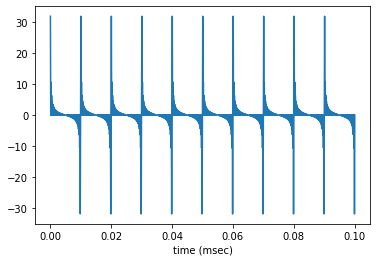

In [ ]:
# parameter setting
amp = 1
sr = 10000
dur = 0.5

F0 = 100
Fend = int(sr/2)  

phase = 0

s_all = 0
for freq in range(F0, Fend+1, F0):                         # for loop를 통해 여러가지 phasor를 만듦. 즉, F0(100)부터 5000(sr이 10000이므로 1초에 5000)Hz까지의 phasor 만듦
  s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
  s_all += s                                               # 위에서 만든 signal (phasor)을 모두 합침 -> 이것이 source -> += 가 무슨 뜻인지 알아야 함 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s_all[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s_all, rate=sr)

- 100Hz부터 nHz까지 해서 다 더하면 위의 그래프처럼 하나의 줄이 만들어짐.
  
  -> 이 하나하나를 train이라고 함. 

  -> 이 train이 쭉 있다고 해서 source를 pulse train이라고 함. 

## Filtering source through vocal tract: Formants
- 우리 입모양 자체가 filter임 (source를 변형시키는 거니까)
  - source를 vocal tract를 통해 변형시키는 것. 즉, 우리의 입모양에 따라서 어떤 부분이 filter in되고 out될지, 어떤 부분이 강화/약화 될지가 달라짐.

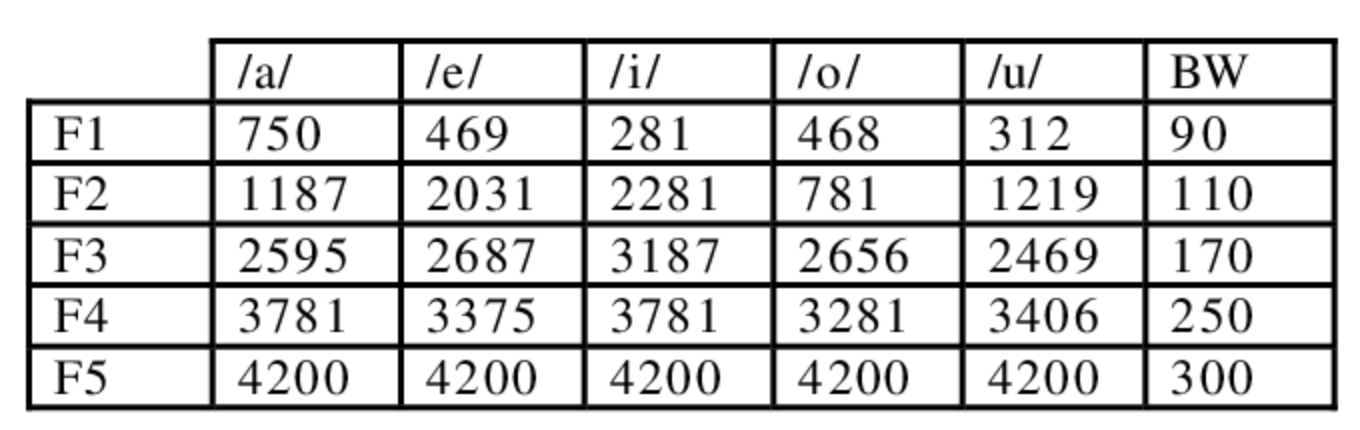

- 위의 그림
  - 표에 나와 있는 수치의 지점에서 해당 소리가 더 공명이 되어 커짐.
  - e.g., 750Hz, 1187Hz, 2595Hz, 3781Hz, 4200Hz에서 세게 들리면 /a/ 모음인 것


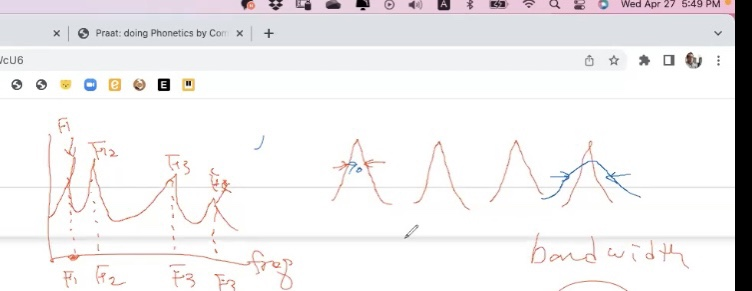

- BW는 bandwidth. 각 peak에서의 width를 나타냄. BW가 클수록 완만한 산

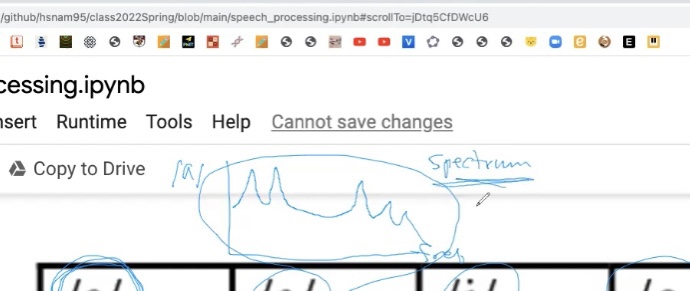

- 위의 그림을 /a/의 filter라고 생각할 수 있음.
- 이 filter 자체가 spectrum !!
- 위에서 각 peak가 차례대로 F1, F2... 이렇게 되는 것
  -> 이 각 peak를 "Formant"라고 함

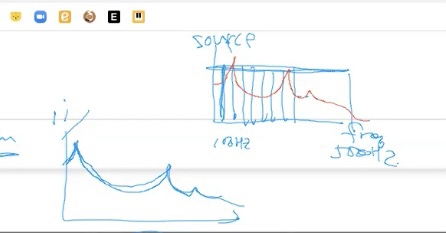

- 위의 예시처럼, /i/소리를 만들고 싶은 경우 source에 /i/ filter를 도장찍듯이 (빨간색 라인처럼)찍어주면 됨! 그러면 line아래의 부분들만 남게 되어서 /i/ 가 산출됨. 이것이 filter된 것

signal -> filter -> output
- 이때, 이 filter에는 a filter와 b filter가 있음.
  - a는 IIR filter이고 b는 FIR filter 
    - a, b filter 각각에 [3] [1/2] 이런식으로 숫자를 넣음 (0425 수업 참조)
  - a, b에 어떤 숫자를 넣어야 할지를 위의 표를 통해 좀 더 직관적으로 알 수 있는 것. 즉, 그 값들을 넣으면 원하는 소리를 산출할 수 있음. 
  - 이렇게 주파수값들을 filter에 넣을 때 주파수 값을 a b coeffienct로 바꿔주는 것이 아래 코드에 나와 있는 함수 (reasonance 함수)

    -> a, b 값을 계산해줌

In [ ]:
def hz2w(F, sr):
    NyFreq = sr/2;
    w = F/NyFreq *np.pi;
    return w

def resonance (srate, F, BW):
    a2 = np.exp(-hz2w(BW,srate))
    omega = F*2*np.pi/srate
    a1 = -2*np.sqrt(a2)*np.cos(omega)
    a = np.array([1, a1, a2])
    b = np.array([sum(a)])
    return a, b

# srate = sampling rate, F = 주파수 (어떤 주파수대를 강하게 하고 싶은지), BW는 표의 값 -> 이것을 resonance 함수에 넣어주면 a, b값을 계산해줌

#### 모음 만들어보기

In [ ]:
s = s_all

In [ ]:
from scipy.signal import lfilter

RG = 0  # RG is the frequency of the Glottal Resonator
BWG = 100  # BWG is the bandwidth of the Glottal Resonator
a, b=resonance(sr,RG,BWG)          #resonance함수 사용 -> a b 값 계산
s = lfilter(b, a, s, axis=0)        
ipd.Audio(s, rate=sr)

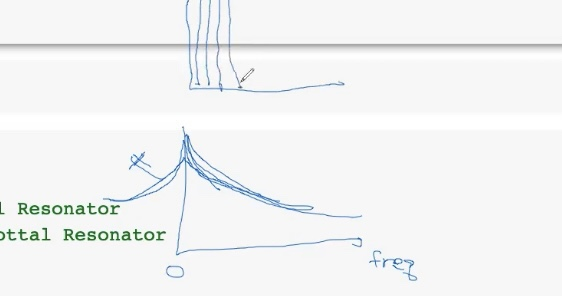

- RG=0, BWG=0의 뜻
  - Filter를 RG=0에 맞춰서 그리라는 것. 그렇게하고, BWG=100대로 filter 모양을 만들어서 그리는 것. 

In [ ]:
RG = 750  # RG is the frequency of the 1st Formant
BWG = 90  # BWG is the bandwidth of the 1st Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 1187  # RG is the frequency of the 2nd Formant
BWG = 110  # BWG is the bandwidth of the 2nd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 2595  # RG is the frequency of the 3rd Formant
BWG = 170  # BWG is the bandwidth of the 3rd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 3781  # RG is the frequency of the 4th Formant
BWG = 250  # BWG is the bandwidth of the 4th Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

고주파로 갈수록 점점 더 약한 (부드러운) 소리가 남 

In [ ]:
s = lfilter(np.array([1, -1]), np.array([1]), s)
ipd.Audio(s, rate=sr)

# a에는 아무것도 안함(1이니까)
# FIR filter만 건드림 -> [1, -1]을 하면 입술의 효과를 줌 (퍼져나가는 듯한 효과)

- 정리
  - 모음은 source -> filter로 이루어져 있고 
    - source는 larynx. filter는 vocal tract (입)
    - 어디에서 공명이 일어나는지(소리가 커지는지)를 F1, F2...Fn을 통해 정해두었음 (filter)
  - source는 다양한 주파수를 가진 phasor들의 합으로 돼있음 

# LPC filter coefficients
- **모음 분석**에만 이용
  - fourier filter anaylsis의 분석 방법과 유사하지만, Fourier는 모든 signal에 적용 가능한 반면 LPC는 모음 분석에만 사용가능
- **H * Y = X (X는 pulse train)**
  - pulse train: 성대가 떨린다는 걸 가정 -> 즉, 여기에서의 X는 모음일 때 성대에서 나는 소리라고 생각하면 됨
  - H는 shift를 하고 wheight를 줘서 더한 값
  - signal Y를 FIR하면 pulse train X가 되는 H의 coefficients를 구하는 것임
    -> signal Y가 모음! 이 모음에 FIR을 하면 원래 있던 pulse train으로 바뀌는 H의 coefficients를 구하는 공식이 H * Y = X (H를 통해 원래의 모음을 구하는 역함수)
  - 즉, X의 관점에서 lfilter의 a계수값을 추정하는 것

In [ ]:
# from google.colab import files
# fn = files.upload()                -> 모음 파일 불러오기


import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')
ipd.Audio(s[7000:12000], rate=sr)    # '아' 구간

# 입모양 filter가 어떻게 생겼는지를 알아내는 과정 

In [ ]:
# 계수값 구하기

import scipy
M = int(sr/1000+4)            # Number of LPC coefficnets
a = librosa.lpc(s[7000:12000], M)

# lpc function -> 특정 모음의 a 값을 구해줌
# M -> 몇개의 coefficient를 구할 것인지 
# 이 원리에 해당하는 것이 위에서 한 LPC filter에 대한 설명

### Spectrum (=filter) plotted from LPC coefficients
- filter 모양 구하기

(0.0, 5000.0)

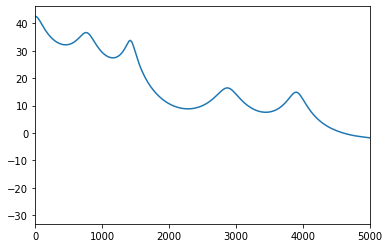

In [ ]:
# 위에서 구한 coefficient를 통해서 입모양 filter('ㅏ'모음을 위한 filter)가 어떻게 생겼는지를 plotting 해주는 함수 (freqz)

w, h = scipy.signal.freqz(1, a)
plt.plot (w*sr/(2*np.pi), 20*np.log10(np.abs(h)))
plt.xlim((0,5000))


# 어떤 frequency대에서 peak를 형성하고 있는지를 보여줌 


### Formants & Bandwidths computed from LPC coefficients (for Grad students only)
- 각 formant&BW 값 구하기

In [ ]:
# 위에서 plotting한 filter의 각 peak의 수치(Formant값)를 정확하게 계산하는 코드

BWcutoff = 2000;
F = np.sort(np.angle(np.roots(a)))
order = np.argsort(np.angle(np.roots(a)))
F = F*sr/(2*np.pi);

BW = -2*np.log(abs(np.roots(a)))*sr/(2*np.pi);
BW = BW[order];

idx = [i for i in range(F.shape[0]) if (F[i] > 0) & (BW[i] < BWcutoff) ]

print(F[idx])
print(BW[idx])


# formant값과 BW값 구했음

[  773.0751  1427.4038  2873.7573  3904.3184  4630.678   5151.7295
  7404.265   7795.8794  8694.367   9274.946  10049.233 ]
[ 229.41571  130.27097  307.47186  229.12651 1215.9471   542.4114
  202.3538   303.34442 1630.4275   210.64189 1169.2583 ]


* LPC coefficient를 통해 Formant 값을 정확히 계산해낼 수 있다!